# `exps_v07.py`

## best to date

1. `BRCA25knl2h1024`
2. `COAD25knl2h1024`
3. `GBM25knl2h1024`

Share these coords

**Specify args**

In [1]:
job_name='v062_woimmune_bst8layer50k_221012_165814'
data_version='cancer_only'
block='bst8layer50k'
approach='2'
model='cAE'
beta=0.0
nocondition=True
binarizeinput=False
initial_lr=0.001
batch_size=1024
nolrscheduler=False
layer_norm=True
inject_c1_eachlayer=False

**run**

In [ ]:
# filepaths
scratch_path = ''
prj_path = ''

mfp = os.path.join(scratch_path, '/model_zoo/dev/')

In [ ]:

bst_mdl_chkpt = os.path.join(mfp, '{}.pt'.format(job_name)) # ~/model_zoo/dev/v062_woimmune_bst8layer50k_221012_165814.pt

In [1]:
import os
import time
import datetime
import numpy as np
from collections import OrderedDict
import tqdm
import argparse
import pickle
import warnings

import scanpy as sc

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append(prj_path)
from drscax.scripts import models as tcgamodels
from drscax.scripts import eval_ as tcgaeval
from drscax.scripts import data as tcgadata
from drscax.scripts import train as tcgatrain

################ load data ################

mfp = os.path.join(scratch_path, '/model_zoo/dev/')
lfp = os.path.join(prj_path, '/experiments/run_logs') # log filepath

if block == 'default':
    block = [50000, 4096, 2048, 1024, 512]
elif block == '1024rep':
    block = [50000, 1024, 1024, 512]
elif block == 'default25k':
    block = [25000, 4096, 2048, 1024, 512]
elif block == 'bst8layer25k':
    block = [25000, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]
elif block == 'bst8layer50k':
    block = [50000, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]
elif block == 'bst4layer50k':
    block = [50000, 1024, 1024, 1024, 1024]
elif block == 'bst4layer25k':
    block = [25000, 1024, 1024, 1024, 1024]

elif block == 'nl8h256':
    block = [50000, 256, 256, 256, 256, 256, 256, 256, 256]
elif block == 'nl8h64':
    block = [50000, 64, 64, 64, 64, 64, 64, 64, 64]
elif block == 'nl4h256':
    block = [50000, 256, 256, 256, 256]
elif block == 'nl4h64':
    block = [50000, 64, 64, 64, 64]
elif block == 'nl2h1024':
    block = [50000, 1024, 1024]
elif block == 'nl2bottleneck':
    block = [50000, 1024, 256]
elif block == 'nl2h256':
    block = [50000, 256, 256]
elif block == 'nl2h64':
    block = [50000, 64, 64]
elif block == 'nl4bottleneck':
    block = [25000, 4096, 1024, 256, 64]

elif block == '25knl8h256':
    block = [25000, 256, 256, 256, 256, 256, 256, 256, 256]
elif block == '25knl8h64':
    block = [25000, 64, 64, 64, 64, 64, 64, 64, 64]
elif block == '25knl4h256':
    block = [25000, 256, 256, 256, 256]
elif block == '25knl4h64':
    block = [25000, 64, 64, 64, 64]
elif block == '25knl2h1024':
    block = [25000, 1024, 1024]
elif block == '25knl4bottleneck':
    block = [25000, 4096, 1024, 256, 64]
elif block == '25knl2bottleneck':
    block = [25000, 1024, 256]
elif block == '25knl2h256':
    block = [25000, 256, 256]
elif block == '25knl2h64':
    block = [25000, 64, 64]

else:
    warnings.warn('invalid block architecture selected. using default')
    block = [50000, 4096, 2048, 1024, 512]

if binarizeinput:
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/tcga_cnt_cnv_220929.h5ad'))
    adata.X = (adata.X > 0.).astype(np.float32)
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cat') if model=='cVAE' else nn.BCELoss(reduction='sum')

elif data_version == 'old_wimmune':
    # adata = sc.read(scratch_path/data/lssc/h5ad/tcga_top50k_221010.h5ad')
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cont') if model=='cVAE' else nn.MSELoss(reduction='sum')
    # assume it's the bad data
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/tcga_top50k_221010.h5ad'))

    # add val set 
    ## randomly pick 5 samples in train
    adata.obs['split'] = adata.obs['split'].astype(str)
    adata.obs.loc[adata.obs['batch'].isin(np.random.choice(adata.obs.loc[adata.obs['split'] == 'train', 'batch'].unique(), 5)), 'split'] = 'val'

    print('val sample batch ids:', adata.obs.loc[adata.obs['split']=='val', 'batch'].unique())

elif data_version == 'cancer_only':
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/tcga_canceronly_top50klogtfidf_221011.h5ad'))
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cont') if model=='cVAE' else nn.MSELoss(reduction='sum')

elif data_version.lower() == 'brca':
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/BRCA_log_tfidf_221016.h5ad'))
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cont') if model=='cVAE' else nn.MSELoss(reduction='sum')
    # add val
    adata.obs['split'] = adata.obs['split'].astype(str)
    adata.obs.loc[adata.obs['batch']==adata.obs['batch'].unique()[0], 'split'] = 'val'

elif data_version.lower() == 'coad':
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/COAD_log_tfidf_221016.h5ad'))
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cont') if model=='cVAE' else nn.MSELoss(reduction='sum')
    # add val
    adata.obs['split'] = adata.obs['split'].astype(str)
    adata.obs.loc[adata.obs['batch']==adata.obs['batch'].unique()[0], 'split'] = 'val'

elif data_version.lower() == 'gbm':
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/GBM_log_tfidf_221016.h5ad'))
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cont') if model=='cVAE' else nn.MSELoss(reduction='sum')
    # add val
    adata.obs['split'] = adata.obs['split'].astype(str)
    adata.obs.loc[adata.obs['batch']==adata.obs['batch'].unique()[0], 'split'] = 'val'
    
elif data_version.lower() == 'blca':
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/BLCA_log_tfidf_221016.h5ad'))
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cont') if model=='cVAE' else nn.MSELoss(reduction='sum')
    # add val
    adata.obs['split'] = adata.obs['split'].astype(str)
    adata.obs.loc[adata.obs['batch']==adata.obs.loc[adata.obs['split']=='train', 'batch'].unique()[0], 'split'] = 'val'

elif data_version.lower() == 'kirc':
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/KIRC_log_tfidf_221016.h5ad'))
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cont') if model=='cVAE' else nn.MSELoss(reduction='sum')
    # add val
    adata.obs['split'] = adata.obs['split'].astype(str)
    adata.obs.loc[adata.obs['batch']==adata.obs.loc[adata.obs['split']=='train', 'batch'].unique()[0], 'split'] = 'val'

elif data_version.lower() == 'kirp':
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/KIRP_log_tfidf_221016.h5ad'))
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cont') if model=='cVAE' else nn.MSELoss(reduction='sum')
    # add val
    adata.obs['split'] = adata.obs['split'].astype(str)
    adata.obs.loc[adata.obs['batch']==adata.obs.loc[adata.obs['split']=='train', 'batch'].unique()[0], 'split'] = 'val'

elif data_version.lower() == 'luad':
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/LUAD_log_tfidf_221016.h5ad'))
    # sample down the big batch
    if False:
        # sample? If you want to sample, switch above to True
        idx = adata.obs.loc[adata.obs['batch']!=3, :].index.to_list()
        idx += adata.obs.loc[adata.obs['batch']==3, :].sample(2000, replace=False).index.to_list()
        adata = adata[idx, :].copy()
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cont') if model=='cVAE' else nn.MSELoss(reduction='sum')
    # add val
    adata.obs['split'] = adata.obs['split'].astype(str)
    adata.obs.loc[adata.obs['batch']==adata.obs.loc[adata.obs['split']=='train', 'batch'].unique()[0], 'split'] = 'val'

elif data_version.lower() == 'skcm':
    adata = sc.read(os.path.join(scratch_path, '/data/lssc/h5ad/SKCM_log_tfidf_221016.h5ad'))
    criterion = tcgatrain.VAELoss(beta=beta, reconstruction='cont') if model=='cVAE' else nn.MSELoss(reduction='sum')
    if False:
        # add val
        adata.obs['split'] = adata.obs['split'].astype(str)
        adata.obs.loc[adata.obs['batch']==adata.obs.loc[adata.obs['split']=='train', 'batch'].unique()[0], 'split'] = 'val'







topn = block[0]

if topn < 50000: #todo(optional): redo this filtering for a proper cnt_rank thing and chk that it can be done
    subset_idx = np.where(adata.var['cnt_rank'].to_numpy().argsort()[::-1].argsort() < topn)[0]
    adata = sc.AnnData(X=adata.X[:, subset_idx], obs=adata.obs, var=adata.var.iloc[subset_idx, :])


############ network ############


if model == 'cVAE':

    net = tcgamodels.cVAE(
        feat_in=adata.shape[1],
        n_hidden=hidden_size,
        enc_feat_out=enc_out_dim,
        nb_layers=nb_layers,
        n_c1_class=0 if nocondition else len(adata.obs['batch'].unique()),
        c1_embed_dim=0 if nocondition else 8,
        inject_c1_eachlayer=inject_c1_eachlayer,
        sigmoid_out=binarizeinput,
        return_latent=False,
    )

elif model == 'cAE':

    net = tcgamodels.cAE_v05(
        layer_io=block,
        layer_norm=layer_norm,
        n_c1_class=0 if nocondition else len(adata.obs['batch'].unique()),
        c1_embed_dim=0 if nocondition else 8,
        inject_c1_eachlayer=inject_c1_eachlayer,
        sigmoid_out=binarizeinput,
        return_latent=False,
    )

else:
    print('\nInvalid model specified [choose one of cVAE or cAE]. Exiting.')
    exit()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.empty_cache()

net = net.to(device)
print(net)

# save_name = '{}v05_{}_noc{}_allL{}_lr{}_topn{}_LN{}_n{}'.format(
#     model,
#     block,
#     nocondition,
#     inject_c1_eachlayer,
#     initial_lr,
#     topn,
#     layer_norm,
#     trial)
save_name = os.path.join(mfp, '{}.pt'.format(job_name))

############### training ###################

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), 
                             lr=initial_lr, 
                             weight_decay = 0.0001)
if not nolrscheduler:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

max_epochs = 500
early_stop = tcgatrain.EarlyStop(patience=50, save_name=save_name)
print("training on ", device)

log = {'save_name': save_name,
       '<loss_train>': [],
       '<loss_val>': [],
       'hyperparameters': {
           'beta': beta,
           'layer_norm': layer_norm,
           'blocks': block,
           'noconditioning': nocondition,
           'approach': approach,
           'model': model,
           # 'hidden_size': hidden_size,
           # 'enc_out_dim': enc_out_dim,
           'initial_lr': initial_lr,
           # 'nb_layers': nb_layers,
           'no_lr_scheduler': nolrscheduler,
           'batch_size': batch_size,
           # 'args': args,
       },
      }
# for epoch in range(max_epochs):

#     # train
#     train_loss, n, start = 0.0, 0, time.time()
#     net.train()
#     for X, y, X_div_cnv, idx in tqdm.tqdm(train_dl):
#         X = X.squeeze().to(device) # squeeze may not be needed
#         X_div_cnv = X_div_cnv.squeeze().to(device)
#         y = y.squeeze().to(device)

#         if approach == '1':
#             if nocondition:
#                 output = net(X_div_cnv)
#             else:
#                 output = net(X_div_cnv, y)
#         elif approach == '2':
#             if nocondition:
#                 output = net(X)
#             else:
#                 output = net(X, y)

#         if model == 'cVAE':
#             Xhat, mean, logvar = output
#         elif model == 'cAE':
#             Xhat = output
#         del output

#         l = criterion(X_div_cnv, Xhat, mean, logvar).to(device) if model=='cVAE' else criterion(Xhat, X_div_cnv).to(device)
#         optimizer.zero_grad()
#         l.backward()
#         optimizer.step()

#         train_loss += l.cpu().item()
#         n += X.shape[0]

#     train_loss /= n
#     log['<loss_train>'].append(train_loss)

#     # val
#     val_loss, n = 0.0, 0
#     net.eval()
#     for X, y, X_div_cnv, idx in tqdm.tqdm(val_dl):
#         X = X.squeeze().to(device)
#         X_div_cnv = X_div_cnv.squeeze().to(device)
#         y = y.squeeze().to(device)

#         if approach == '1':
#             if nocondition:
#                 output = net(X_div_cnv)
#             else:
#                 output = net(X_div_cnv, y)
#         elif approach == '2':
#             if nocondition:
#                 output = net(X)
#             else:
#                 output = net(X, y)

#         if model == 'cVAE':
#             Xhat, mean, logvar = output
#         elif model == 'cAE':
#             Xhat = output
#         del output

#         l = criterion(X_div_cnv, Xhat, mean, logvar).to(device) if model=='cVAE' else criterion(X_div_cnv, Xhat).to(device)

#         val_loss += l.cpu().item()
#         n += X.shape[0]

#     val_loss /= n
#     log['<loss_val>'].append(val_loss)


#     print('epoch %d\ttrain loss: %.4f\tval loss: %.4f\ttime: %.1f-s'
#           % (epoch, train_loss, val_loss, time.time() - start))

#     if not nolrscheduler:
#         #todo: modify to ReduceLRonPleteau
#         # adjust_lr(optimizer)
#         scheduler.step(val_loss)

#     if (early_stop(val_loss, net, optimizer)):
#         break

# ## dump log
# log_fname = os.path.join(lfp, os.path.split(save_name)[1].split('.pt')[0] + '.pkl')
# with open(log_fname, 'wb') as f:
#     pickle.dump(log, f, protocol=pickle.HIGHEST_PROTOCOL)
#     f.close()
# print('\nDone with optimization. Log dumped at')
# print(' ', log_fname)

# print('\n Starting eval...')

# eval
checkpoint = torch.load(early_stop.save_name)
# redefine net with outputting latent
if model == 'cVAE':
    net = tcgamodels.cVAE(
        feat_in=adata.shape[1],
        n_hidden=hidden_size,
        enc_feat_out=enc_out_dim,
        nb_layers=nb_layers,
        n_c1_class=0 if nocondition else len(adata.obs['batch'].unique()),
        c1_embed_dim=0 if nocondition else 8,
        inject_c1_eachlayer=inject_c1_eachlayer,
        sigmoid_out=binarizeinput,
        return_latent=True,
    )
elif model == 'cAE':

    net = tcgamodels.cAE_v05(
        layer_io=block,
        layer_norm=layer_norm,
        n_c1_class=0 if nocondition else len(adata.obs['batch'].unique()),
        c1_embed_dim=0 if nocondition else 8,
        inject_c1_eachlayer=inject_c1_eachlayer,
        sigmoid_out=binarizeinput,
        return_latent=True,
    )

if device.type == 'cuda':
    torch.cuda.empty_cache()

net = net.to(device)
net.load_state_dict(checkpoint["net"])

# del data_train, train_dl, data_val, val_dl
data_test = tcgadata.tcga(adata, split='all')
test_dl = torch.utils.data.DataLoader(
    data_test,
    shuffle=True,
    batch_size=batch_size)

## eval scripts
evaluator = tcgaeval.eval_model(
    test_dl,
    adata.obs,
    net, 
    log,
    approach=approach, 
    nocondition=nocondition,
    model_name=model,
    save_name=save_name,
    device=device,
    pfp=os.path.join(prj_path, '/results'),
)





In [ ]:
def viz_umap(mat, barcodes, md, use_pca=False, plot_file=None, include_leiden=True, optional_color='tissue'):
    from sklearn.decomposition import PCA
    # make adata for approach 1
    tdata = sc.AnnData(X=mat.numpy(), obs=md.loc[barcodes, :])
    if 'tissue' not in tdata.obs.columns:
        tdata.obs['tissue'] = tdata.obs['Sample'].apply(lambda s: s.split('_')[1])
    if 'n_idx' not in tdata.obs.columns:
        # add a numerical index
        tdata.obs['n_idx'] = np.arange(tdata.shape[0])
    if use_pca:
        pca = PCA(n_components=30)
        pca.fit(tdata.X)
        tdata.obsm['X_pca'] = pca.transform(tdata.X)
        sc.pp.neighbors(tdata, n_pcs=30)
    else:
        sc.pp.neighbors(tdata, n_pcs=0, use_rep=None) # use .X
    if include_leiden:
        sc.tl.leiden(tdata)
    sc.tl.umap(tdata)
    if plot_file is not None:
        sc.settings.figdir, save_name = os.path.split(plot_file)
    else:
        save_name = None
    if include_leiden:
        colors = ['batch', optional_color, 'leiden']
    else:
        colors = ['batch', optional_color]
    sc.pl.umap(tdata, color=colors,
               save=save_name)
    return tdata

In [ ]:
def gen_npoutput(AnnData, model, 
                 return_ZtoPCA_adata=True, # this is the best so far
                 exp_name='bst8layer25k_woimmune',
                 save_path=os.path.join(scratch_path, '/tmp/'), 
                 chunk_size=1024,
                optional_color='tissue'):
    print('Loading data...')
    tic = time.time()
    
    # assume full adata wanted
    exp_name = '{}_{}'.format(exp_name, datetime.datetime.today().strftime('%y%m%d_%H%M%S'))
    N = AnnData.shape[0]
    barcodes = []

    model.eval()
    count = 0
    for i in tqdm.tqdm(range(0, N, chunk_size)):
        x = torch.tensor(AnnData.X[i:i+chunk_size].toarray(), dtype=torch.float32)
        x = x.to(device)
        n = x.shape[0]

        xhat, z = model(x)

        barcodes += AnnData.obs.iloc[i:i+chunk_size].index.to_list()

        if i==0:
            X = torch.empty(N, x.shape[1])
            # X_div_cnv = torch.empty(N, x_div_cnv.shape[1])
            Xhat = torch.empty(N, xhat.shape[1])
            Z = torch.empty(N, z.shape[1])
        X[count:count+n] = x.detach().cpu()
        # X_div_cnv[count:count+n] = x_div_cnv.detach().cpu()
        Xhat[count:count+n] = xhat.detach().cpu()
        Z[count:count+n] = z.detach().cpu()
        count += n
        
    print('\n  generating UMAPs. sec elapsed: {:.0f}'.format(time.time() - tic))
    if save_path is not None:
        plot_file1 = os.path.join(save_path, 'Z_{}.png'.format(exp_name))
        plot_file2 = os.path.join(save_path, 'Zto30dPCA_{}.png'.format(exp_name))
    else:
        plot_file1, plot_file2 = None, None
    tdata_Z = viz_umap(Z, barcodes, AnnData.obs, use_pca=False, plot_file=plot_file1, include_leiden=False, optional_color=optional_color)
    tdata_Z_PCA = viz_umap(Z, barcodes, AnnData.obs, use_pca=True, plot_file=plot_file2, include_leiden=False, optional_color=optional_color)
        
    if save_path is not None:
        print('\n  saving. sec elapsed: {:.0f}'.format(time.time() - tic))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        np.save(os.path.join(save_path, 'X_{}.npy'.format(exp_name)), X.numpy())
        np.save(os.path.join(save_path, 'Xhat_{}.npy'.format(exp_name)), Xhat.numpy())
        np.save(os.path.join(save_path, 'Z_{}.npy'.format(exp_name)), Z.numpy())
        np.save(os.path.join(save_path, 'barcodes_{}.npy'.format(exp_name)), np.array(barcodes))
        np.save(os.path.join(save_path, 'Z_umap_{}.npy'.format(exp_name)), tdata_Z.obsm['X_umap'])
        np.save(os.path.join(save_path, 'Zto30dPCA_umap_{}.npy'.format(exp_name)), tdata_Z_PCA.obsm['X_umap'])
        
        
    print('\n  DONE. sec elapsed: {:.0f}'.format(time.time() - tic))
    
    if return_ZtoPCA_adata:
        return tdata_Z_PCA
    else:
        return tdata_Z
        
    

    
    

In [ ]:
print('Model checkpt loaded: ', save_name)

In [ ]:
tdata = gen_npoutput(adata, net, 
                 return_ZtoPCA_adata=True, # this is the best so far
                 exp_name='v062_woimmune_bst8layer50k_',
                 save_path=os.path.join(scratch_path, '/tmp/'), 
                 chunk_size=1024,
                    optional_color='tissue')

In [12]:
tdata

AnnData object with n_obs × n_vars = 200936 × 1024
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'batch', 'split', 'batch_id', 'tissue', 'n_idx'
    uns: 'neighbors', 'umap', 'tissue_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

/home/nravindra/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


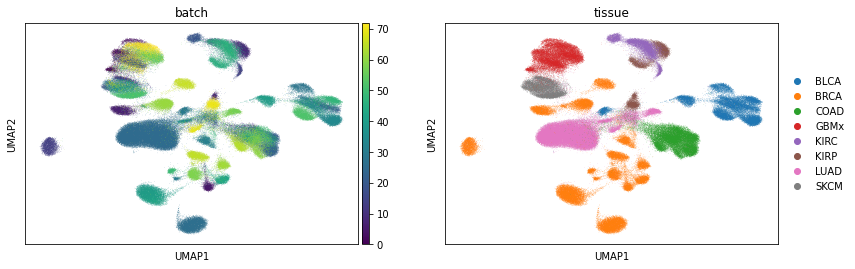

In [14]:
# sc.pl.umap(tdata, color=['batch', 'tissue'])

In [17]:
exp_name = 'v062_woimmune_bst8layer50k'
exp_name = '{}_{}'.format(exp_name, datetime.datetime.today().strftime('%y%m%d_%H%M%S'))

In [15]:
tdata.write(os.path.join(scratch_path, '/tmp/adata_v062_woimmune_bst8layer50k.h5ad'))

In [20]:
save_path = os.path.join(scratch_path, '/tmp/')

In [21]:
np.save(os.path.join(save_path, '30dPCA_{}.npy'.format(exp_name)), tdata.obsm['X_pca'])
np.save(os.path.join(save_path, 'umapcoords_fromZto30dPCA_{}.npy'.format(exp_name)), tdata.obsm['X_umap'])

In [23]:
os.path.join(save_path, '30dPCA_{}.npy'.format(exp_name))

'/illumina/scratch/deep_learning/nravindra/tmp/30dPCA_v062_woimmune_bst8layer50k_221107_122338.npy'